In [2]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import albumentations as A

2023-09-21 02:18:23.363924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# defining Conv2d block for our u-net
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x



# Now defining Unet a
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [4]:
with tf.device('/gpu:0'):    
    inputImage = tf.keras.layers.Input((128, 128, 6), name='img')
    net=GiveMeUnet(inputImage)
    net.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

2023-09-21 02:18:27.494134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-21 02:18:27.510781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-21 02:18:27.511072: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

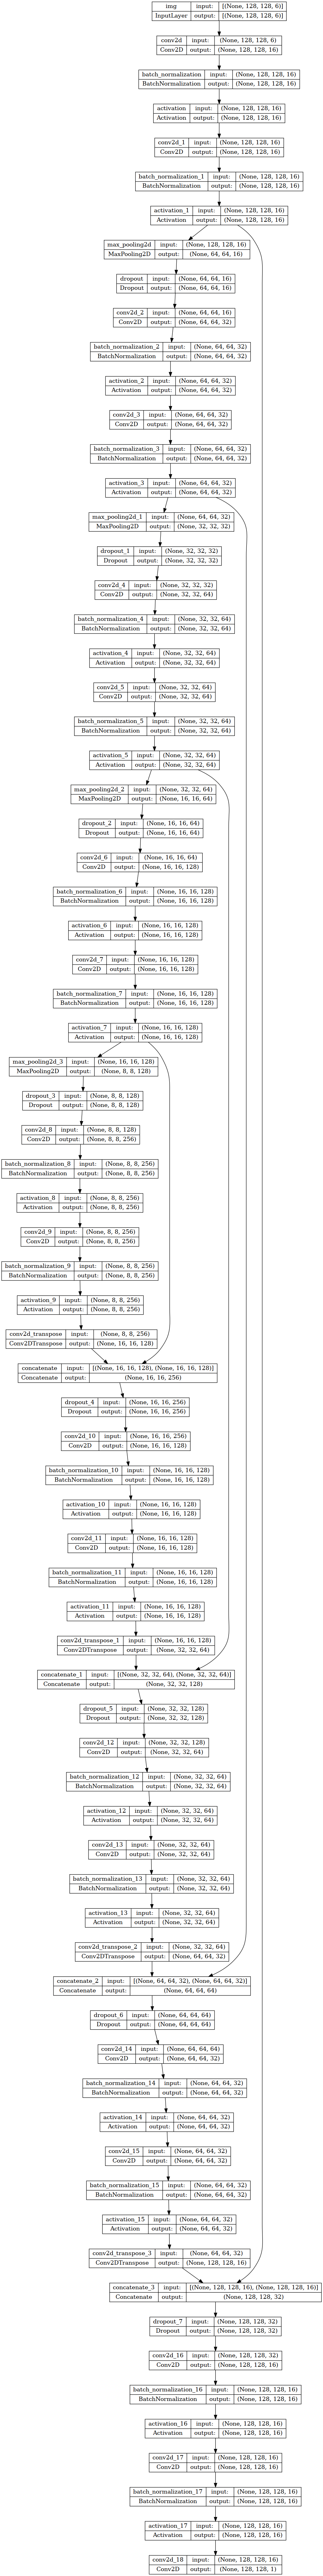

In [5]:
tf.keras.utils.plot_model(net, show_shapes=True)

In [32]:
transform=A.Compose([
    A.Sharpen()])

In [38]:
pred=[]
for i in range(len(a)):
    transformed=transform(image=a[i])
    pred.append(transformed['image'])


In [37]:
transformed

{'image': array([[[213, 213, 213],
         [218, 218, 218],
         [218, 218, 218],
         ...,
         [202, 202, 202],
         [181, 181, 181],
         [188, 188, 188]],
 
        [[211, 211, 211],
         [217, 217, 217],
         [218, 218, 218],
         ...,
         [203, 203, 203],
         [190, 190, 190],
         [206, 206, 206]],
 
        [[206, 206, 206],
         [212, 212, 212],
         [215, 215, 215],
         ...,
         [211, 211, 211],
         [195, 195, 195],
         [210, 210, 210]],
 
        ...,
 
        [[183, 186, 184],
         [180, 183, 181],
         [183, 184, 182],
         ...,
         [118, 115, 117],
         [114, 111, 113],
         [103, 100, 102]],
 
        [[188, 190, 190],
         [183, 185, 185],
         [185, 187, 187],
         ...,
         [110, 107, 109],
         [112, 109, 111],
         [110, 107, 109]],
 
        [[191, 193, 193],
         [186, 188, 188],
         [187, 189, 189],
         ...,
         [103, 100,

In [5]:
imagenames=glob.glob("*.jpeg")

In [6]:
os.listdir()

['img0.jpeg',
 'img1.jpeg',
 'img2.jpeg',
 'img3.jpeg',
 'img4.jpeg',
 'img5.jpeg',
 'img6.jpeg',
 'main.ipynb']

In [24]:
a=[]
for i in range(len(imagenames)):
    img=cv2.imread(imagenames[i])
    img=cv2.resize(img,(1140,610),interpolation=cv2.INTER_LANCZOS4)
    a.append(img)

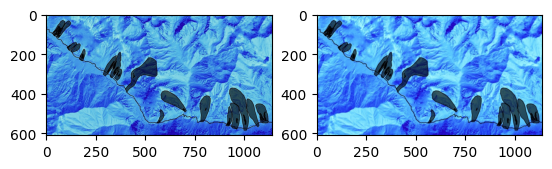

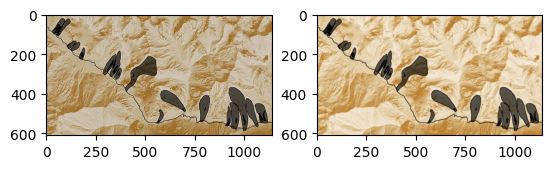

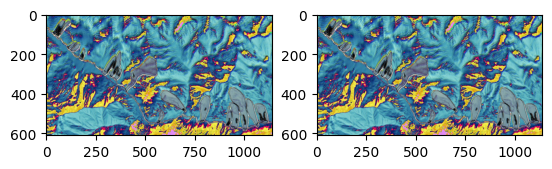

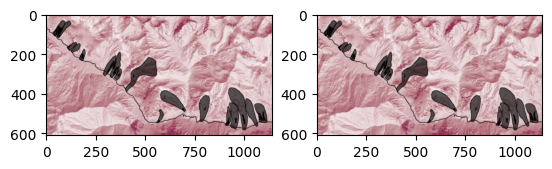

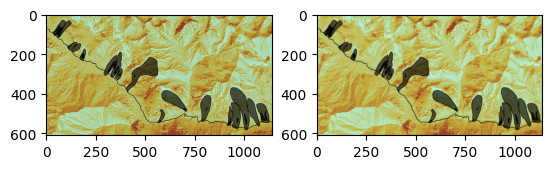

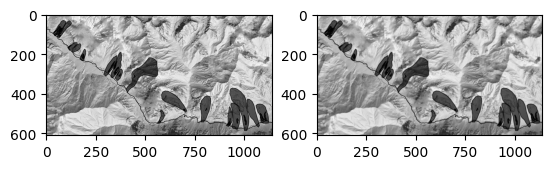

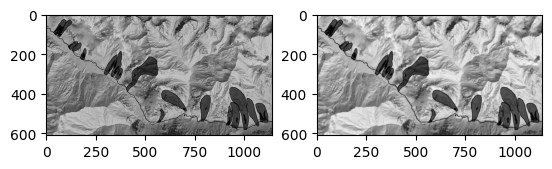

In [39]:
for n in range(len(a)):
    plt.subplot(1,2,1)
    plt.imshow(pred[n])
    plt.subplot(1,2,2)
    plt.imshow(a[n])
    plt.show()
plt.show()